In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = InceptionV3(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 36s 11ms/step - loss: 0.4124 - acc: 0.8581 - val_loss: 0.6237 - val_acc: 0.8361
Epoch 2/100
3144/3144 [==============================] - 28s 9ms/step - loss: 0.2278 - acc: 0.9173 - val_loss: 0.1740 - val_acc: 0.9390
Epoch 3/100
3144/3144 [==============================] - 29s 9ms/step - loss: 0.2102 - acc: 0.9243 - val_loss: 0.3675 - val_acc: 0.8996
Epoch 4/100
3144/3144 [==============================] - 49s 16ms/step - loss: 0.1586 - acc: 0.9437 - val_loss: 4.8563 - val_acc: 0.5172
Epoch 5/100
3144/3144 [==============================] - 59s 19ms/step - loss: 0.1132 - acc: 0.9602 - val_loss: 0.8245 - val_acc: 0.8399
Epoch 6/100
3144/3144 [==============================] - 59s 19ms/step - loss: 0.1192 - acc: 0.9593 - val_loss: 0.4403 - val_acc: 0.8666
Epoch 7/100
3144/3144 [==============================] - 58s 19ms/step - loss: 0.1678 - acc: 0.9408 - val_loss: 3.1153 - val_acc: 0.5

3144/3144 [==============================] - 61s 19ms/step - loss: 0.3064 - acc: 0.9132 - val_loss: 7.6952 - val_acc: 0.4956
Epoch 61/100
3144/3144 [==============================] - 60s 19ms/step - loss: 0.0948 - acc: 0.9685 - val_loss: 0.8001 - val_acc: 0.8640
Epoch 62/100
3144/3144 [==============================] - 61s 19ms/step - loss: 0.0811 - acc: 0.9720 - val_loss: 0.1898 - val_acc: 0.9301
Epoch 63/100
3144/3144 [==============================] - 59s 19ms/step - loss: 0.0514 - acc: 0.9841 - val_loss: 0.2009 - val_acc: 0.9441
Epoch 64/100
3144/3144 [==============================] - 60s 19ms/step - loss: 0.0387 - acc: 0.9885 - val_loss: 0.1956 - val_acc: 0.9517
Epoch 65/100
3144/3144 [==============================] - 63s 20ms/step - loss: 0.0803 - acc: 0.9761 - val_loss: 0.3302 - val_acc: 0.8996
Epoch 66/100
3144/3144 [==============================] - 62s 20ms/step - loss: 0.0314 - acc: 0.9889 - val_loss: 0.2113 - val_acc: 0.9390
Epoch 67/100
3144/3144 [=======================

3145/3145 [==============================] - 69s 22ms/step - loss: 0.2001 - acc: 0.9345 - val_loss: 0.3310 - val_acc: 0.9453
Epoch 19/100
3145/3145 [==============================] - 62s 20ms/step - loss: 0.1644 - acc: 0.9574 - val_loss: 0.7649 - val_acc: 0.6743
Epoch 20/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.1745 - acc: 0.9447 - val_loss: 0.5394 - val_acc: 0.8995
Epoch 21/100
3145/3145 [==============================] - 67s 21ms/step - loss: 0.2727 - acc: 0.9145 - val_loss: 0.8777 - val_acc: 0.6972
Epoch 22/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.1940 - acc: 0.9456 - val_loss: 0.3091 - val_acc: 0.9377
Epoch 23/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.1864 - acc: 0.9517 - val_loss: 0.2092 - val_acc: 0.9313
Epoch 24/100
3145/3145 [==============================] - 68s 21ms/step - loss: 0.1590 - acc: 0.9507 - val_loss: 0.3213 - val_acc: 0.8906
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 65s 21ms/step - loss: 0.0350 - acc: 0.9895 - val_loss: 0.3334 - val_acc: 0.9427
Epoch 78/100
3145/3145 [==============================] - 68s 22ms/step - loss: 0.0133 - acc: 0.9965 - val_loss: 0.2229 - val_acc: 0.9593
Epoch 79/100
3145/3145 [==============================] - 67s 21ms/step - loss: 0.0039 - acc: 0.9990 - val_loss: 0.2136 - val_acc: 0.9631
Epoch 80/100
3145/3145 [==============================] - 64s 20ms/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.2947 - val_acc: 0.9415
Epoch 81/100
3145/3145 [==============================] - 68s 22ms/step - loss: 0.0602 - acc: 0.9790 - val_loss: 0.5271 - val_acc: 0.8779
Epoch 82/100
3145/3145 [==============================] - 66s 21ms/step - loss: 0.0335 - acc: 0.9917 - val_loss: 0.3071 - val_acc: 0.9415
Epoch 83/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.0127 - acc: 0.9955 - val_loss: 0.2376 - val_acc: 0.9504
Epoch 84/100
3145/3145 [=======================

3145/3145 [==============================] - 61s 19ms/step - loss: 0.1414 - acc: 0.9542 - val_loss: 0.0969 - val_acc: 0.9695
Epoch 36/100
3145/3145 [==============================] - 60s 19ms/step - loss: 0.1218 - acc: 0.9587 - val_loss: 0.1745 - val_acc: 0.9338
Epoch 37/100
3145/3145 [==============================] - 63s 20ms/step - loss: 0.1157 - acc: 0.9577 - val_loss: 0.1031 - val_acc: 0.9720
Epoch 38/100
3145/3145 [==============================] - 61s 19ms/step - loss: 0.1136 - acc: 0.9663 - val_loss: 0.0999 - val_acc: 0.9656
Epoch 39/100
3145/3145 [==============================] - 60s 19ms/step - loss: 0.1046 - acc: 0.9660 - val_loss: 0.1890 - val_acc: 0.9160
Epoch 40/100
3145/3145 [==============================] - 61s 19ms/step - loss: 0.1125 - acc: 0.9625 - val_loss: 0.1827 - val_acc: 0.9288
Epoch 41/100
3145/3145 [==============================] - 60s 19ms/step - loss: 0.1010 - acc: 0.9644 - val_loss: 0.1025 - val_acc: 0.9669
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 63s 20ms/step - loss: 0.0310 - acc: 0.9898 - val_loss: 0.0863 - val_acc: 0.9809
Epoch 95/100
3145/3145 [==============================] - 63s 20ms/step - loss: 0.0082 - acc: 0.9975 - val_loss: 0.0784 - val_acc: 0.9746
Epoch 96/100
3145/3145 [==============================] - 62s 20ms/step - loss: 0.0082 - acc: 0.9975 - val_loss: 0.3643 - val_acc: 0.9262
Epoch 97/100
3145/3145 [==============================] - 59s 19ms/step - loss: 0.0471 - acc: 0.9860 - val_loss: 0.1338 - val_acc: 0.9682
Epoch 98/100
3145/3145 [==============================] - 61s 20ms/step - loss: 0.0743 - acc: 0.9736 - val_loss: 0.1279 - val_acc: 0.9669
Epoch 99/100
3145/3145 [==============================] - 64s 20ms/step - loss: 0.0508 - acc: 0.9831 - val_loss: 0.1231 - val_acc: 0.9707
Epoch 100/100
786/786 [==============================] - 6s 8ms/step
[2] Test acurracy: 0.9580 (6173.4227 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [======

3145/3145 [==============================] - 61s 19ms/step - loss: 0.0427 - acc: 0.9876 - val_loss: 0.4857 - val_acc: 0.8295
Epoch 53/100
3145/3145 [==============================] - 63s 20ms/step - loss: 0.0149 - acc: 0.9962 - val_loss: 0.2049 - val_acc: 0.9555
Epoch 54/100
3145/3145 [==============================] - 64s 20ms/step - loss: 0.0196 - acc: 0.9930 - val_loss: 2.0558 - val_acc: 0.7824
Epoch 55/100
3145/3145 [==============================] - 62s 20ms/step - loss: 0.0197 - acc: 0.9955 - val_loss: 2.6119 - val_acc: 0.6438
Epoch 56/100
3145/3145 [==============================] - 61s 19ms/step - loss: 0.0461 - acc: 0.9851 - val_loss: 1.1154 - val_acc: 0.8117
Epoch 57/100
3145/3145 [==============================] - 60s 19ms/step - loss: 0.0594 - acc: 0.9812 - val_loss: 0.2740 - val_acc: 0.9351
Epoch 58/100
3145/3145 [==============================] - 61s 19ms/step - loss: 0.0160 - acc: 0.9949 - val_loss: 0.4269 - val_acc: 0.9160
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 62s 20ms/step - loss: 0.2764 - acc: 0.9113 - val_loss: 0.3346 - val_acc: 0.9046
Epoch 11/100
3145/3145 [==============================] - 61s 19ms/step - loss: 0.2859 - acc: 0.9157 - val_loss: 0.4478 - val_acc: 0.8282
Epoch 12/100
3145/3145 [==============================] - 63s 20ms/step - loss: 0.3278 - acc: 0.9033 - val_loss: 0.8323 - val_acc: 0.8664
Epoch 13/100
3145/3145 [==============================] - 71s 23ms/step - loss: 0.2660 - acc: 0.9199 - val_loss: 0.3713 - val_acc: 0.9160
Epoch 14/100
3145/3145 [==============================] - 63s 20ms/step - loss: 0.2789 - acc: 0.9164 - val_loss: 0.2809 - val_acc: 0.9071
Epoch 15/100
3145/3145 [==============================] - 60s 19ms/step - loss: 0.2381 - acc: 0.9310 - val_loss: 0.2366 - val_acc: 0.9275
Epoch 16/100
3145/3145 [==============================] - 61s 19ms/step - loss: 0.2424 - acc: 0.9224 - val_loss: 3.9893 - val_acc: 0.6654
Epoch 17/100
3145/3145 [=======================

3145/3145 [==============================] - 61s 19ms/step - loss: 0.0991 - acc: 0.9682 - val_loss: 0.2094 - val_acc: 0.9275
Epoch 70/100
3145/3145 [==============================] - 60s 19ms/step - loss: 0.1439 - acc: 0.9507 - val_loss: 0.1747 - val_acc: 0.9491
Epoch 71/100
3145/3145 [==============================] - 62s 20ms/step - loss: 0.0857 - acc: 0.9692 - val_loss: 0.1460 - val_acc: 0.9440
Epoch 72/100
3145/3145 [==============================] - 62s 20ms/step - loss: 0.0856 - acc: 0.9746 - val_loss: 0.1531 - val_acc: 0.9555
Epoch 73/100
3145/3145 [==============================] - 64s 20ms/step - loss: 0.0779 - acc: 0.9758 - val_loss: 0.1403 - val_acc: 0.9555
Epoch 74/100
3145/3145 [==============================] - 63s 20ms/step - loss: 0.1037 - acc: 0.9657 - val_loss: 0.2785 - val_acc: 0.9211
Epoch 75/100
3145/3145 [==============================] - 65s 21ms/step - loss: 0.0913 - acc: 0.9698 - val_loss: 0.1408 - val_acc: 0.9606
Epoch 76/100
3145/3145 [=======================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9407


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

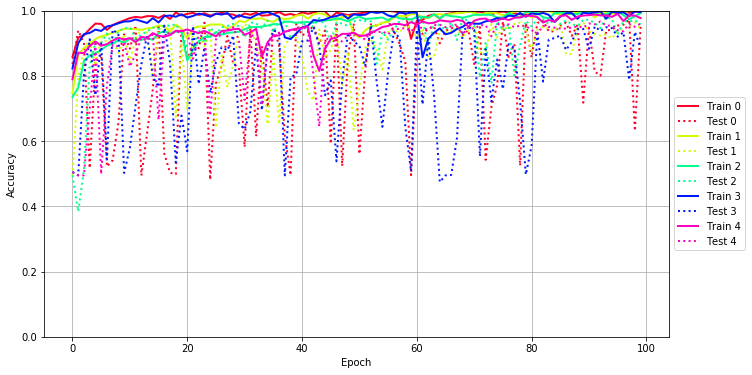

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

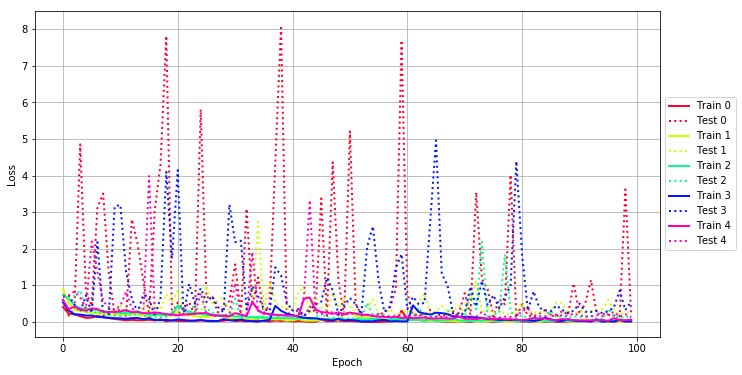

In [12]:
plot_loss(history)

Plotting the confusion matrix


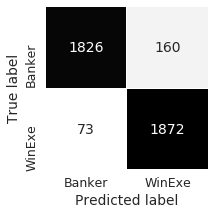

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


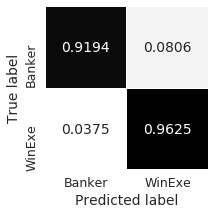

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'loss': [0.41244587229692753, 0.22780761062037247, 0.21020755149973863, 0.15857717028935145, 0.1131964486860137, 0.11923142407876237, 0.16777747667586532, 0.12836666543595968, 0.10669659167224821, 0.08170656355586065, 0.0655509195321313, 0.046184310734594294, 0.05870340398273433, 0.04617613356065185, 0.04967423687207941, 0.06124824339153041, 0.04218123192483033, 0.07266052973897459, 0.01809896911439929, 0.04430654803504243, 0.028213651211423985, 0.024552529727810232, 0.03593782712195931, 0.027581792461562015, 0.042315845163278375, 0.032161739088462205, 0.01788871266881215, 0.02866044529694732, 0.03336609107336745, 0.06059119522775364, 0.024499863656308813, 0.03415996092549376, 0.01855776571528275, 0.03891324602380281, 0.0362982344708486, 0.027351605761754764, 0.014383441642692204, 0.04186914317930738, 0.028337236488790135, 0.0428334044321599, 0.014318260029725536, 0.028645300041557156, 0.015347588264221047, 0.006143778659336378, 0.00848768668955147, 0.06709897260622384, 0.018305793416

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

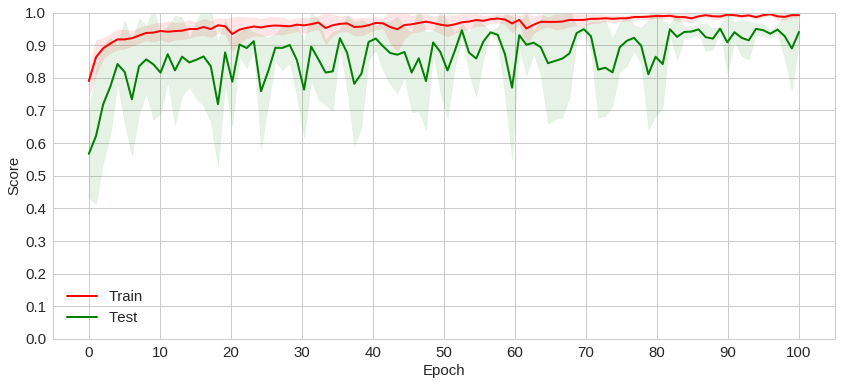

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

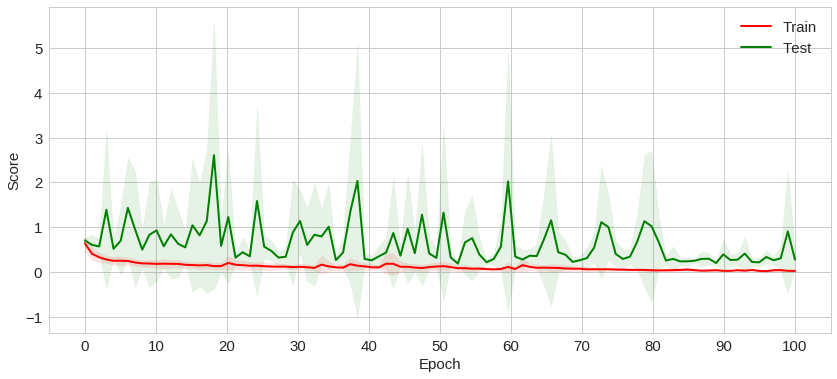

In [19]:
plot_mean_loss(history)

In [36]:
hist = [{'loss': [0.41244587229692753, 0.22780761062037247, 0.21020755149973863, 0.15857717028935145, 0.1131964486860137, 0.11923142407876237, 0.16777747667586532, 0.12836666543595968, 0.10669659167224821, 0.08170656355586065, 0.0655509195321313, 0.046184310734594294, 0.05870340398273433, 0.04617613356065185, 0.04967423687207941, 0.06124824339153041, 0.04218123192483033, 0.07266052973897459, 0.01809896911439929, 0.04430654803504243, 0.028213651211423985, 0.024552529727810232, 0.03593782712195931, 0.027581792461562015, 0.042315845163278375, 0.032161739088462205, 0.01788871266881215, 0.02866044529694732, 0.03336609107336745, 0.06059119522775364, 0.024499863656308813, 0.03415996092549376, 0.01855776571528275, 0.03891324602380281, 0.0362982344708486, 0.027351605761754764, 0.014383441642692204, 0.04186914317930738, 0.028337236488790135, 0.0428334044321599, 0.014318260029725536, 0.028645300041557156, 0.015347588264221047, 0.006143778659336378, 0.00848768668955147, 0.06709897260622384, 0.01830579341642805, 0.02613980033696788, 0.038868713117993746, 0.025566083505280487, 0.02592956013302141, 0.017240840886274006, 0.009170352029048366, 0.002828441085387199, 0.000922998297287438, 0.00038469378124612516, 0.007634277742780016, 0.020691575476507695, 0.02897382285146744, 0.30641175954633465, 0.09477206151790292, 0.08108190838816284, 0.051398867800471586, 0.03866074887061677, 0.08026449231394749, 0.03135579682853424, 0.020770201514994622, 0.006194606979535158, 0.007289654810081411, 0.01248771413834486, 0.012152960781787367, 0.007952974198762126, 0.028002963371995662, 0.03593042923099629, 0.014041781688521382, 0.008408899497277142, 0.021913687733052956, 0.024972742203525748, 0.03891292265225344, 0.03757376674652744, 0.008277109003733634, 0.0068325461747582306, 0.0016812925383186915, 0.0025904582462803185, 0.005602150800426361, 0.01637571575802143, 0.002621873727006987, 0.0025056621154788622, 0.004043916417697549, 0.016058672094042183, 0.0162134070083657, 0.030492450945812773, 0.014913731661729848, 0.04321725025335232, 0.010688945811680867, 0.003668035108471451, 0.0015562071638583668, 0.02011720196442045, 0.014119844706761638, 0.005121208658488112], 'val_loss': [0.6236995974794655, 0.17401421668417422, 0.367507885803091, 4.856303317585944, 0.8245195184674988, 0.44032123135852486, 3.115262418966676, 3.5134667312329704, 1.3037648603247343, 0.2145237665921639, 0.37058118293405035, 0.1668560789114638, 2.802977476304508, 2.136891122571319, 1.1244988517470071, 0.20114206999133244, 3.065747325423409, 4.317808751980092, 7.820755523915597, 0.2325015008127674, 0.5336311548945182, 0.3321465774518562, 0.5367137724955373, 0.17936669883591608, 5.810230960006787, 0.6688797438216634, 0.6920514952680131, 0.2592795504472459, 0.37680646084163816, 0.5827500995620138, 1.573731821631537, 0.2133639080608512, 3.094552073860005, 0.45785706231827356, 1.2160110181857853, 0.24165068551178506, 0.4642360505777094, 4.385072934960774, 8.105185603550165, 0.16073335135376893, 0.35749744710592446, 0.28249937161481364, 0.14955278247798376, 0.42200630476634376, 0.26178408713565765, 3.375530987297259, 0.16526505205037104, 4.367527355055361, 1.1181312488213149, 0.16056604742095007, 5.209769255588609, 0.49943172763157373, 0.19406432582342376, 0.19507328394843026, 0.1744969070944083, 0.20226608318245048, 0.2589766869872922, 0.40363696777040503, 0.9034029377657194, 7.695175553679948, 0.8000584404032176, 0.18976812990763364, 0.20089287456986524, 0.19563886784537773, 0.33022999127301966, 0.2113284788199782, 0.1789373252185812, 0.16683395013785324, 0.2914326072598333, 0.24283278204282932, 0.7861408538658062, 0.20140328243602035, 3.5407209502630117, 1.1658083059383602, 0.8980517058569365, 0.1466101183209289, 0.6308155022271621, 0.4810823317252696, 4.019613100816106, 0.12897648407664655, 0.4849219510220512, 0.17220324059957792, 0.15594332482135623, 0.22902546326950515, 0.32670061984200033, 0.18232052575375557, 0.14604329074267888, 0.30462549724338017, 0.2046869645424612, 1.0547072940122626, 0.2173444457938528, 0.5036126094215858, 1.1450204620113575, 0.225477002362284, 0.22864590629527293, 0.19855747833039453, 0.17857815742935262, 0.15515773014160728, 3.62363796999268, 0.17701863405132592], 'val_acc': [0.8360864045962294, 0.9390088955965248, 0.8996188055908514, 0.5171537484116899, 0.8398983481575604, 0.866581956797967, 0.5222363405336722, 0.5412960609911055, 0.6556543837357052, 0.9275730624132266, 0.8831003817245648, 0.9542566714323157, 0.49428208386277, 0.6238881829733164, 0.7598475222363406, 0.9580686149936467, 0.56162643000919, 0.5031766200762389, 0.49809402795425667, 0.9453621357490026, 0.8526048284625158, 0.8919949184681893, 0.8843710292249047, 0.963151207115629, 0.4815756040879702, 0.7763659460268906, 0.832274459974587, 0.9224904712000827, 0.8373570522480422, 0.8246505723217694, 0.5819567981184361, 0.9479034307496823, 0.6149936467598475, 0.8907242686200172, 0.7039390088945362, 0.947903431279838, 0.8945362139990248, 0.6162642960021275, 0.49555273189326554, 0.9606099115847936, 0.9237611192305781, 0.9339263029443869, 0.9542566709021602, 0.8970775095298602, 0.9390088955965248, 0.5921219822109276, 0.9580686160539581, 0.5235069885641678, 0.8627700127064803, 0.9606099121149492, 0.5603557814485387, 0.8157560361083005, 0.9580686149936467, 0.9542566709021602, 0.9618805590851334, 0.9669631512071156, 0.9377382475660293, 0.8983481575603558, 0.8437102916431548, 0.49555273189326554, 0.8640406608884489, 0.9301143583227446, 0.9440914866581956, 0.9517153753713247, 0.899618806121007, 0.9390088955965248, 0.9453621352188469, 0.951715374841169, 0.9250317663522354, 0.9402795436270204, 0.8360864040660737, 0.9491740793103336, 0.5425667095517567, 0.7052096569250318, 0.7712833545108005, 0.9669631512071156, 0.8576874198271328, 0.8970775105901716, 0.5247776365946633, 0.9618805596152891, 0.8564167730841582, 0.9618805596152891, 0.9695044472681067, 0.936467599005378, 0.936467599005378, 0.9542566714323157, 0.9631512076457847, 0.922490470669927, 0.9567979669631512, 0.717916137760143, 0.9479034307496823, 0.8132147392899441, 0.8005082597423538, 0.9390088955965248, 0.9415501905972046, 0.9542566709021602, 0.9567979669631512, 0.9733163913595934, 0.6315120711562897, 0.9542566709021602], 'acc': [0.8581424936386769, 0.9173027989821882, 0.9243002544529262, 0.9437022900763359, 0.9602417302798982, 0.9592875318066157, 0.9408396946564885, 0.9557888040712468, 0.9634223918575063, 0.9701017811704835, 0.9770992366412213, 0.9809160305343512, 0.9786895674300254, 0.9831424936386769, 0.9831424936386769, 0.977735368956743, 0.986323155216285, 0.9745547073791349, 0.9942748091603053, 0.9850508905852418, 0.9901399491094147, 0.9930025445292621, 0.9869592875318066, 0.9920483460559797, 0.9847328244274809, 0.9901399491094147, 0.9933206106870229, 0.989821882951654, 0.9879134860050891, 0.9809160305343512, 0.9914122137404581, 0.9872773536895675, 0.9936386768447837, 0.9847328244274809, 0.9856870229007634, 0.9901399491094147, 0.9955470737913485, 0.9866412213740458, 0.989821882951654, 0.9853689567430025, 0.9949109414758269, 0.9904580152671756, 0.9942748091603053, 0.9990458015267175, 0.9977735368956743, 0.9790076335877863, 0.9936386768447837, 0.9904580152671756, 0.9860050890585241, 0.989821882951654, 0.9914122137404581, 0.9942748091603053, 0.9971374045801527, 0.9993638676844784, 0.9993638676844784, 1.0, 0.9974554707379135, 0.9945928753180662, 0.9920483460559797, 0.9131679389312977, 0.9685114503816794, 0.9720101781170484, 0.9840966921119593, 0.9885496183206107, 0.976145038167939, 0.9888676844783715, 0.9920483460559797, 0.9984096692111959, 0.9977735368956743, 0.9958651399491094, 0.9958651399491094, 0.9968193384223919, 0.9917302798982188, 0.9875954198473282, 0.9955470737913485, 0.9974554707379135, 0.9939567430025446, 0.9920483460559797, 0.9885496183206107, 0.9872773536895675, 0.996501272264631, 0.9984096692111959, 1.0, 0.9990458015267175, 0.9974554707379135, 0.9961832061068703, 0.9996819338422391, 0.9990458015267175, 0.9987277353689568, 0.9968193384223919, 0.9933206106870229, 0.989821882951654, 0.9955470737913485, 0.9872773536895675, 0.9961832061068703, 0.9987277353689568, 1.0, 0.9933206106870229, 0.996501272264631, 0.9984096692111959]},
{'loss': [0.9011916980834379, 0.49975135383242075, 0.3312716905566581, 0.30420768597831027, 0.2750985073408376, 0.23701152346187251, 0.23986135841553086, 0.21796321773661717, 0.19729832890302842, 0.20060801188800548, 0.20273215617267903, 0.2072839523915835, 0.214659427847885, 0.19164164629194808, 0.18103831546863805, 0.15497102651090638, 0.17438436856520007, 0.20012313310880162, 0.16439541606484231, 0.17451438215844015, 0.27271449932612374, 0.1939743404547626, 0.18638822985472475, 0.15903445341593225, 0.13461904320599355, 0.137200258939641, 0.16402675451648632, 0.17320746145491, 0.14017096186954, 0.09911020999516705, 0.10064935649616351, 0.07502202268153879, 0.07671946761552215, 0.07061032913447564, 0.10534840584902866, 0.09746473684924727, 0.07422484069683594, 0.07028999009742645, 0.07135669061268528, 0.052226614355685604, 0.038441846548729175, 0.079437794052479, 0.03857206019849793, 0.035272823479574396, 0.03695290631752325, 0.07348176759500383, 0.08231906514371995, 0.06037480843820519, 0.061413790610143605, 0.24985370779786087, 0.24014371075861404, 0.16858171236202335, 0.12539056158655684, 0.12310632912409514, 0.09564561504627828, 0.09588722840828054, 0.060384473363929596, 0.046231283773394194, 0.048798528550539184, 0.029804168811544705, 0.044712671784877284, 0.058454285239851154, 0.06679143275597706, 0.039226982292433425, 0.030319675261862515, 0.0394461614381824, 0.02928127016953973, 0.0227707040571313, 0.0204166753111342, 0.013194405208169653, 0.018378491416708262, 0.03628378691712901, 0.019339589583902177, 0.013992218511543328, 0.017637224920724767, 0.03436383716186467, 0.03499163277565675, 0.013284865165179646, 0.0039027106790508726, 0.005524040103463577, 0.06018780429324873, 0.03351802397360181, 0.012705421373166666, 0.003492244621383438, 0.022933241035952123, 0.024870940971163075, 0.025852137467111735, 0.02263039821057043, 0.013352507520770574, 0.0040099994136747535, 0.012069719646197102, 0.07640955068914305, 0.02685943003995596, 0.024376435960318733, 0.03054360319613753, 0.011215726404031812, 0.020185031360692204, 0.0034265865706678282, 0.0012762999140377273, 0.006685122070540318], 'val_loss': [0.7687034841257198, 0.6799118104023485, 0.45319629807508627, 0.2756824868022637, 0.41289831845814945, 0.2583477672274786, 0.28125632522063704, 0.24483069576531571, 0.357547598637394, 0.27223106190258917, 0.45117233333393514, 0.2551175669717197, 0.21364832823058122, 0.23492316704518315, 0.4546414055972912, 0.22341546532875708, 0.5089957147609186, 0.3310324760964354, 0.7649112032115004, 0.5394459476187332, 0.8777409339508483, 0.30908139616857655, 0.2091602657284142, 0.32128871912871304, 0.233195017293361, 0.9912038622684682, 0.5077084083603007, 0.6012529833171204, 0.6794577020128038, 0.26812827568169467, 0.22915475690410336, 0.274209011620996, 0.36706218769911286, 0.4836388383506212, 2.7373191865656343, 0.31668016246256936, 1.1083719358606496, 0.5325928591291003, 0.4263451333529773, 0.37684712372016715, 0.3614137920837745, 0.7965031024992807, 0.9889095041476683, 0.20111119524639753, 0.659446938043939, 0.399432776616673, 0.3250556319250557, 0.7916061075134132, 0.38167180894440367, 0.6778957159767928, 0.4266394882180915, 0.30012048172359246, 0.2382187682794023, 0.3387437672674201, 0.6199511893641004, 0.19851363737031855, 0.21780445462782363, 0.3608017718606904, 0.18265633170822346, 0.26914230336964784, 0.33039053254606765, 0.22343813726067088, 0.5401291596328807, 0.7860475867599295, 0.24427362973150102, 0.2891762833900124, 0.4430629610014089, 0.2872801090101297, 0.3416219339910397, 0.45473467360479336, 0.23328178273133268, 0.6317938400323457, 1.112243162937588, 0.23529618594774138, 0.4169326262816943, 0.22342979937493232, 0.3334495933802263, 0.22291366718575428, 0.21362012458356297, 0.29474797922952434, 0.5270646701178787, 0.3071341883324788, 0.23756851179927527, 0.26952858899294047, 0.2637980358210646, 0.26064684081931644, 0.5415159276575229, 0.4943913489671391, 0.2534934565289842, 0.20458398119258545, 0.29879284869939765, 0.2849534269630833, 0.3119526930134412, 0.3176644835172342, 0.3637442366681719, 0.5981007699218942, 0.32094431599503903, 0.22689805293865098, 0.24159019556672326, 0.3023077742819871], 'val_acc': [0.494910941475827, 0.7951653959186933, 0.8854961847227645, 0.9083969480815431, 0.8320610680956271, 0.9173027983755252, 0.9045801526717557, 0.9083969459582224, 0.8702290077852536, 0.9274809154238713, 0.8409669205129299, 0.9173027989821882, 0.9427480909963903, 0.9325699739480443, 0.8040712468193384, 0.9452926202584769, 0.9389312971032606, 0.94529262086514, 0.6743002538462631, 0.8994910941475827, 0.6972010178117048, 0.9376590330788804, 0.9312977114403217, 0.8905852411236168, 0.9389312977099237, 0.6412213740458015, 0.8625954207573229, 0.764631043560329, 0.8346055994810342, 0.9338422385790875, 0.9580152665689095, 0.9465648848895202, 0.896946565037162, 0.8396946558818865, 0.6513994910941476, 0.8689567423958815, 0.6526717557251909, 0.8944020365334042, 0.9173028004988459, 0.916030533744482, 0.8600508905852418, 0.7519083969465649, 0.7251908396946565, 0.9427480916030534, 0.8549618323644003, 0.8791348600508906, 0.9452926202584769, 0.7735368956743003, 0.8740458015267175, 0.6335877862595419, 0.7659033078880407, 0.8854961832061069, 0.910941475826972, 0.8804071246819338, 0.8193384223918575, 0.9402035623409669, 0.9402035623409669, 0.9338422385790875, 0.955470737913486, 0.9465648854961832, 0.9173027989821882, 0.94529262086514, 0.8536895674300254, 0.8562340968437777, 0.9402035617343039, 0.9351145038167938, 0.9376590324722174, 0.94529262086514, 0.916030534351145, 0.9414758269720102, 0.9643765903307888, 0.871501271657968, 0.8753180663094265, 0.9592875318066157, 0.9173027989821882, 0.9516539440203562, 0.9427480909963903, 0.9592875318066157, 0.9631043256997456, 0.9414758269720102, 0.8778625954198473, 0.941475827123676, 0.950381679389313, 0.9465648848895202, 0.9376590330788804, 0.960559796437659, 0.8664122138921238, 0.8676844783715013, 0.950381679389313, 0.9631043256997456, 0.9363867684478372, 0.9287531806615776, 0.9236641215307415, 0.9274809160305344, 0.9147582697201018, 0.9363867678411741, 0.94529262086514, 0.9529262086513995, 0.9631043256997456, 0.9452926202584769], 'acc': [0.7468998410553924, 0.8632750397835324, 0.8858505564766961, 0.89602543722086, 0.9131955486791881, 0.921462639109698, 0.925596184438666, 0.9322734501100307, 0.9373608903020668, 0.9446740858505565, 0.9443561208267091, 0.9430842607881761, 0.9402225755356454, 0.9459459459838503, 0.947535771084135, 0.9545310015898251, 0.9519872814369504, 0.9344992050874403, 0.9573926868044516, 0.9446740858695086, 0.9144674087745776, 0.9456279811116205, 0.9516693163941509, 0.9507154213036566, 0.9573926868044516, 0.9577106518282988, 0.9573926868234037, 0.944356121016231, 0.9516693163751987, 0.9685214626391097, 0.9643879173290938, 0.975516693163752, 0.9748807631160572, 0.9767885532591415, 0.9685214626391097, 0.9656597774244833, 0.9771065182829889, 0.9742448330873147, 0.9761526232114467, 0.9844197138314785, 0.9879173291127519, 0.9751987281399046, 0.9891891891891892, 0.9920508744038156, 0.9882352941176471, 0.9764705882542463, 0.9710651828298887, 0.9806041335453101, 0.9837837837837838, 0.9287758346960919, 0.9173290937996821, 0.9399046104928458, 0.9516693163751987, 0.9542130367554996, 0.9631160572526565, 0.9659777424483307, 0.9786963434022258, 0.9847376788553259, 0.9818759936406996, 0.989825119236884, 0.9879173290937997, 0.9806041337348319, 0.9764705882352941, 0.9875993640699523, 0.9891891891891892, 0.9866454689984102, 0.9904610492845787, 0.992368839427663, 0.9926868044515104, 0.9968203497615262, 0.993322734499205, 0.9872813990461049, 0.992368839427663, 0.9942766295707473, 0.9920508744038156, 0.9860095389507154, 0.9895071542130366, 0.9965023847376788, 0.9990461049284579, 0.9987281399235627, 0.9790143084450253, 0.9917329093799682, 0.9955484896661367, 0.9987281399046105, 0.9914149445456427, 0.9885532591414944, 0.9898251192558362, 0.9910969793512256, 0.9952305246422893, 0.9990461049284579, 0.9965023849272008, 0.9793322734499205, 0.9930047694753578, 0.9933227345181572, 0.989825119236884, 0.9958664546899841, 0.9945945945945946, 0.9990461049284579, 1.0, 0.9977742450225903]},
{'loss': [0.7476701046590396, 0.6332507127608707, 0.4573238901379377, 0.3767322722224249, 0.36185021120906824, 0.3492351607317386, 0.3182982595812156, 0.30383643406326327, 0.2598949442038665, 0.27557100149520064, 0.24219657677345702, 0.24814211785888066, 0.25755946423461595, 0.265486739881467, 0.24780510661143376, 0.20232973078618177, 0.19479880086568277, 0.19448674061529586, 0.19422716798767187, 0.1897785447739266, 0.45084970265579527, 0.32260290602242814, 0.2839313905076116, 0.23541525470622962, 0.2208850907312857, 0.19111698333333899, 0.19808619212246661, 0.18443190356885306, 0.175891793124816, 0.17542737992939395, 0.15399334978886742, 0.1516937767473806, 0.1461961656192907, 0.12537467546719577, 0.14141107735435798, 0.12184286672852945, 0.11568825705441838, 0.11359027276061393, 0.1046063268145573, 0.11254955821793484, 0.10100942798941996, 0.09533813875553529, 0.10680216344248131, 0.08990807068698546, 0.08805927219423088, 0.08550615197666499, 0.06794876743297557, 0.08465540926186857, 0.08706077586589989, 0.0724530794697744, 0.058400584451723934, 0.08009449932479931, 0.06800919190250539, 0.0700246890843957, 0.08128017831256167, 0.08170329082301198, 0.051093103749668654, 0.07455548322826197, 0.07960000781309813, 0.08808744146069586, 0.05246914679892302, 0.055447556339026635, 0.0642598270671072, 0.032353562134390605, 0.06571211141662965, 0.036185145363306394, 0.047141277368087174, 0.047100539146574576, 0.07584432525536569, 0.04936815305940203, 0.031719795390015945, 0.031243681840765897, 0.04154369723594441, 0.029096513407361146, 0.06505102723872434, 0.05490673070089427, 0.020644866106572703, 0.05694893236865774, 0.05607040394067954, 0.01620265598629493, 0.012810411891901484, 0.02099616564292052, 0.05551642950014204, 0.06882721934769605, 0.025428954716209196, 0.02285951224580668, 0.021261070663515118, 0.027303622840994017, 0.0329407771048881, 0.013886983517375264, 0.017722482959827222, 0.020359186937703805, 0.04025969125350992, 0.031044633346587563, 0.008192555118716412, 0.008228448436955294, 0.04705988237151613, 0.07426411734097334, 0.05076201518609622, 0.022199473064096677], 'val_loss': [0.745132101401118, 0.7210091596644647, 0.7114897143598125, 0.8639920840736564, 0.2598069313600773, 0.3478199176054268, 0.2122579602567294, 0.2773116861515069, 0.20299963016091413, 0.1703583087592028, 0.1671141473998247, 0.23094690915282445, 0.17276674129884054, 0.22789216496562228, 0.17469128761582703, 0.1500260915427111, 0.12659938513057226, 0.13077495872746897, 0.13381236518612344, 0.22199097637835957, 0.3795731094957308, 0.3501355432675388, 0.2016733091599462, 0.5198594989212415, 0.15939802524773522, 0.380817730539021, 0.2590071386053362, 0.1686815394600498, 0.19542624839313763, 0.1322107675269663, 0.6381111862588171, 0.10827890915781942, 0.13499805553989253, 0.1269062629642567, 0.09692756518361374, 0.17453001534362483, 0.10314410704522188, 0.09985476374950819, 0.18900130026672823, 0.18268413637597683, 0.10252230207769926, 0.14683173949481876, 0.15741533988170828, 0.08494223856175219, 0.13474980088628583, 0.27969713561889953, 0.10195578086372399, 0.10682143687517039, 0.17849571801589934, 0.08140466608102351, 0.09955455547639432, 0.09747274754374613, 0.09765610783704516, 0.5220201057512266, 0.185610106522952, 0.21696801737612043, 0.16565609619414798, 0.09979360701359866, 0.08843299440826875, 0.09763201644629922, 0.07872379373071203, 0.08982939763425947, 0.3976898080480946, 0.11608004035711354, 0.1588776978846573, 0.15861560641278444, 0.1138529952013576, 0.3226471092072849, 0.06888720296967879, 0.22707664364032135, 0.14525080930590323, 0.7704035479020868, 0.34161610855856017, 2.185999541588746, 0.10463042531823669, 0.19109754000835444, 0.24264203349420416, 1.8419910092639473, 0.28479430024718283, 0.1225683242052233, 0.19214086603995653, 0.10024684923819477, 0.08898507920697388, 0.13566329241102282, 0.11292209478483817, 0.30389541074036414, 0.11737506044554612, 0.1610629161068596, 0.12343047618979716, 0.15720957317483056, 0.12491999283707263, 0.14680120689941348, 0.1645870965931555, 0.08630629900102942, 0.07839703011442314, 0.3642688509964741, 0.1337626332305177, 0.12787386463983483, 0.12307726778919423, 0.1961159775697205], 'val_acc': [0.494910941475827, 0.38422391918172666, 0.5114503816793893, 0.8307888034645837, 0.9020356234096693, 0.9020356235613349, 0.9300254452926209, 0.8931297709923665, 0.9376590324722174, 0.94529262086514, 0.9491094141516067, 0.9147582712367595, 0.926208651399491, 0.9363867684478372, 0.9478371501272265, 0.9440203562340967, 0.9541984732824428, 0.9541984732824428, 0.9580152665689095, 0.9300254452926209, 0.8880407133781879, 0.876590330182141, 0.9414758269720102, 0.9007633589302917, 0.9478371501272265, 0.9287531806615776, 0.9491094162749274, 0.9529262086513995, 0.9592875311999527, 0.9516539440203562, 0.9173027998921829, 0.9643765903307888, 0.960559796437659, 0.9465648854961832, 0.9694656488549618, 0.9338422385790875, 0.9720101781170484, 0.9656488549618321, 0.916030534351145, 0.9287531806615776, 0.9669211195928753, 0.9452926210168057, 0.9529262086513995, 0.9770992366412213, 0.955470737913486, 0.9020356234096693, 0.9631043256997456, 0.960559796437659, 0.9529262086513995, 0.9669211195928753, 0.9707379134860051, 0.9681933842239185, 0.9669211195928753, 0.8371501272264631, 0.9351145038167938, 0.910941475826972, 0.9414758269720102, 0.9681933842239185, 0.9770992366412213, 0.9643765903307888, 0.9783715012722646, 0.9745547073791349, 0.8842239194850582, 0.9643765903307888, 0.9541984732824428, 0.941475827730339, 0.9643765903307888, 0.9096692111959288, 0.9783715012722646, 0.9669211195928753, 0.9529262086513995, 0.7964376590330788, 0.900763358171963, 0.77735368956743, 0.9681933842239185, 0.9389312978615895, 0.9580152671755725, 0.801526718163915, 0.8931297711440321, 0.9694656488549618, 0.9516539440203562, 0.9745547073791349, 0.9732824427480916, 0.9592875327166104, 0.9720101788753771, 0.9592875325649446, 0.9694656488549618, 0.9592875319582815, 0.9529262086513995, 0.9720101781170484, 0.972010178268714, 0.9618320610687023, 0.9465648854961832, 0.9809160305343512, 0.9745547073791349, 0.9262086515511568, 0.9681933842239185, 0.9669211195928753, 0.9707379134860051, 0.9580152671755725], 'acc': [0.7351351352109439, 0.7643879173859504, 0.845468998429127, 0.8632750397835324, 0.8693163751987282, 0.8788553259520538, 0.8931637521768033, 0.8982511923688394, 0.9096979332842016, 0.901112877602418, 0.9144674087745776, 0.9074721780793655, 0.9106518284884091, 0.915739268869967, 0.9106518282988871, 0.9303656597774245, 0.9370429252971716, 0.9294117647248346, 0.9351351351540873, 0.9351351351540873, 0.8470588235862684, 0.8804451510428625, 0.9062003180029282, 0.9189189191084408, 0.9198728140094132, 0.9344992052769623, 0.926550079491256, 0.931637519872814, 0.9332273451815728, 0.9354531001589825, 0.9430842609208415, 0.949443561397789, 0.9494435612651236, 0.951033386327504, 0.9542130365659778, 0.9586645469377454, 0.9577106519041076, 0.9662957074721781, 0.9659777424483307, 0.9624801271860095, 0.964387917348046, 0.9650238473767886, 0.9631160574232263, 0.9701112877583465, 0.9694753577106519, 0.9713831478726883, 0.9764705882352941, 0.9732909379968203, 0.9672496025437202, 0.9761526232114467, 0.9818759938302214, 0.9742448330683625, 0.975516693163752, 0.9771065183208932, 0.9790143084639775, 0.9701112877583465, 0.9834658187788886, 0.9764705882731985, 0.975198728177809, 0.9729729731624949, 0.9809220985881096, 0.9809220985691574, 0.9786963434022258, 0.988871224184294, 0.9764705882352941, 0.9869634342117795, 0.9828298887122416, 0.9815580288063741, 0.9783783783783784, 0.982193958664547, 0.9872813990461049, 0.9872813990461049, 0.9872813990461049, 0.9872813990840094, 0.9783783783783784, 0.9793322734499205, 0.9930047696648796, 0.9837837837837838, 0.9786963434022258, 0.9961844197138314, 0.9955484898556587, 0.9930047695132621, 0.97965023849272, 0.9764705882542463, 0.9920508744038156, 0.9936406995230525, 0.9936406995230525, 0.9895071542130366, 0.989825119236884, 0.9945945945945946, 0.9936406995230525, 0.993322734499205, 0.9860095389507154, 0.989825119236884, 0.997456279809221, 0.997456279809221, 0.986009539007572, 0.9736089032101897, 0.983147853736089, 0.992368839427663]},
{'loss': [0.534734680277365, 0.312592481429702, 0.21050732547509082, 0.2036152956595671, 0.1761573041944701, 0.17662954080275398, 0.1399937166365986, 0.12859539386767463, 0.1154572558789166, 0.1034233087955105, 0.09862850858387204, 0.08838941512691577, 0.10582126709728817, 0.1114359582219101, 0.07758397269514293, 0.10571995415711488, 0.054295293717913105, 0.049860943332077585, 0.05812537229970832, 0.0392670780141943, 0.0685009157175527, 0.0568019299961135, 0.03364243945180896, 0.040127562368451504, 0.05885835183497121, 0.03060927927695416, 0.029969356283663946, 0.024734306938365837, 0.0785521742494685, 0.04485254198644423, 0.050377710327648206, 0.06348538699134924, 0.036348807292569146, 0.02037418520941276, 0.010206107410568217, 0.036216022590373674, 0.056491589569597725, 0.44024165515300767, 0.30747597482890504, 0.22782154898196222, 0.18694054390554019, 0.14507372654109768, 0.1145774479132199, 0.10464413583941982, 0.10080686356570269, 0.0747147455657514, 0.060937801619698494, 0.04102828639051588, 0.08865988143262216, 0.04224442343311962, 0.05775790363431735, 0.04270692871012155, 0.014904212237325376, 0.01963627510685592, 0.019702588997894916, 0.046106977108125655, 0.05939343563726672, 0.016022746246574602, 0.02421534308713575, 0.01625795573046481, 0.015901319850317612, 0.4555228737631549, 0.27291481762129477, 0.22985870619267462, 0.20355884702861404, 0.25372842209138247, 0.2424139480759495, 0.21063439341910503, 0.15536896521743795, 0.14070033485363037, 0.1374370232295535, 0.14101192793899198, 0.12056408783210669, 0.11045301583594093, 0.07637310209069609, 0.07799933224750627, 0.05687196356316936, 0.0583410010861147, 0.04711974813219379, 0.07000162750837913, 0.036635671188797216, 0.04614576531591898, 0.025949371524972453, 0.04812160317737177, 0.11685340980242565, 0.07288925229839756, 0.03373432466804697, 0.02740250174962991, 0.07648012181936463, 0.03520630005273645, 0.026652451046403434, 0.02343339538605164, 0.015724389629944897, 0.06841470778414303, 0.011610029555489983, 0.0239998702167138, 0.014686158830107491, 0.05305729418080922, 0.009177508791804977, 0.014566453255265833], 'val_loss': [0.6908889071631977, 0.7251165717006033, 0.47283145428917184, 0.2788807741406613, 0.726417783676213, 0.24437701178871038, 2.183831057172392, 0.16159255810214665, 0.2218723770695485, 3.15594473635984, 3.1996745777342457, 1.3742013710809269, 0.6401669852454547, 0.26714320293137134, 0.7475389981294008, 0.6445416038614193, 0.1577958710226242, 0.6543655816190722, 4.1040128449750615, 1.7354757725130814, 4.148795338168044, 0.19064090899535416, 1.0409964654954866, 0.5015902814974311, 0.9211967177973449, 0.5440575287845602, 0.7055007054715752, 0.4094536116408331, 0.26195821158455224, 3.2089656833722198, 2.182842868482149, 2.222749709254474, 0.33988033640779003, 0.9850031223536752, 0.6998901374936672, 0.35045177754934204, 0.29969495398397666, 1.494309838275892, 1.2707730034987132, 0.5333139320442088, 0.31344934480866704, 0.3503255936253162, 0.17062834792464743, 0.30768719914608633, 0.4852002619104531, 0.5518565800410645, 1.2126199868258856, 0.8655206096991328, 0.20072774805185448, 0.45704369762386304, 0.6547414410049031, 0.48571324023316226, 0.2049171767925071, 2.0558371780554214, 2.611935852121182, 1.115413680028066, 0.2739595243797351, 0.4269261370325175, 1.4816594436011128, 1.8558666519536318, 0.35184948326446325, 0.6891720586150657, 0.4840822996377338, 0.5225262225205055, 2.7717105662853054, 4.9637932581810755, 1.316867553778277, 1.0046554847831337, 0.2057189553900226, 0.20501416642929762, 0.23651109821620486, 0.9668214930074512, 0.4224678521144083, 1.123275350876456, 0.4549215664037292, 0.7344948655473064, 0.37698883936520067, 0.6779431919560251, 1.0079542624541384, 4.392760627204128, 1.8381962590476464, 0.3144335877378388, 0.837840979807458, 0.387460427236703, 0.3234714792505779, 0.2968369084990965, 0.44947444073116505, 0.33314284659524, 0.23730839375624524, 0.3107932735585226, 0.5041668038346044, 0.28139044496742655, 0.273356774911929, 0.298551471245122, 0.24208761497137657, 0.2909483186161245, 0.39687740706788904, 0.8561355523746129, 0.3258312756702797, 0.5662090978988046], 'val_acc': [0.5050890585241731, 0.494910941475827, 0.8040712462126753, 0.9122137398513522, 0.7404580146605125, 0.9045801520650927, 0.5432569977588023, 0.9414758278820048, 0.9287531821782352, 0.5025445292620865, 0.5788804086413396, 0.7099236635154743, 0.8358778641120774, 0.9249363861617848, 0.7977099236641222, 0.7659033094046983, 0.9541984747991004, 0.8409669220295874, 0.5343511457964968, 0.6781170498627136, 0.5687022915929935, 0.9529262101680571, 0.7748091618220011, 0.8880407129231906, 0.7480916033567666, 0.8422391854473046, 0.8880407129231906, 0.8778625964815077, 0.9236641230473992, 0.6539440206595656, 0.6361323162799574, 0.6908396961731462, 0.8969465651888278, 0.694656490066276, 0.8905852420336114, 0.9389312986199182, 0.9338422393374164, 0.494910941475827, 0.7964376584264158, 0.8040712462126753, 0.9058524166961359, 0.9083969480815431, 0.9491094162749274, 0.893129771902361, 0.7404580167838332, 0.7862595435013905, 0.5381679389312977, 0.7862595419847328, 0.9312977114403217, 0.9058524176061306, 0.8918575072713177, 0.8295165409568612, 0.9554707394301436, 0.7824427480916031, 0.6437659036112195, 0.811704834605598, 0.9351145047267885, 0.9160305346544766, 0.6424936401935024, 0.5076335893029171, 0.9414758278820048, 0.7124681935358896, 0.9147582691134387, 0.7417302792915558, 0.47455470753080065, 0.494910941475827, 0.4961832070168648, 0.6094147576630571, 0.9402035638576246, 0.9491094162749274, 0.9402035617343039, 0.5534351148071484, 0.8816793897679744, 0.7213740459531924, 0.8498727750535533, 0.7595419841261614, 0.8969465664021539, 0.8854961829027753, 0.7201017826871411, 0.4974554714962423, 0.5852417317965558, 0.937659033988875, 0.7824427496082607, 0.9109414761303035, 0.9160305352611396, 0.9236641218340731, 0.8791348615675482, 0.9045801529750872, 0.942748092513048, 0.9440203571440913, 0.882951654854015, 0.9516539455370139, 0.937659034595538, 0.9491094156682643, 0.9465648864061778, 0.9198473291542694, 0.9338422394890822, 0.7875318073741049, 0.9351145053334515, 0.8854961847227645], 'acc': [0.8225755167121159, 0.9001589825308759, 0.9281399048000147, 0.9316375199296706, 0.9418124006738344, 0.9376788553827707, 0.9513513513513514, 0.9548489666136725, 0.96120826709062, 0.9666136725149777, 0.9672496025437202, 0.9729729729919252, 0.9675675675865197, 0.9621621621621622, 0.9771065184725108, 0.963751987281399, 0.983147853736089, 0.9850556438791733, 0.9812400635930048, 0.9888712242032462, 0.9786963434022258, 0.9837837837837838, 0.9907790143084261, 0.9872813990461049, 0.9812400635930048, 0.9907790143084261, 0.9879173290937997, 0.9926868044704625, 0.9751987281399046, 0.986327503993515, 0.9802861687109845, 0.9774244833068363, 0.9866454689984102, 0.9926868044515104, 0.9958664546899841, 0.988871224184294, 0.9812400635930048, 0.9179650239042334, 0.9128775835037232, 0.9300476947914815, 0.9484896661556772, 0.95325914153234, 0.9713831478726883, 0.9688394277008615, 0.9726550081386475, 0.9802861685214627, 0.9834658187599364, 0.9888712241653418, 0.975516693163752, 0.9885532591414944, 0.9866454689984102, 0.9875993640699523, 0.9961844197138314, 0.9930047694753578, 0.9955484896661367, 0.9850556438791733, 0.9812400635930048, 0.9949125598079639, 0.9907790143084261, 0.9942766295707473, 0.9939586645468999, 0.8569157392686805, 0.9138314785942174, 0.9322734499205088, 0.9456279809789552, 0.92750397475232, 0.9319554848966614, 0.9437201907979665, 0.9503974562798092, 0.9634340222575517, 0.9599364070331349, 0.9599364071847525, 0.9672496025626723, 0.9704292527821939, 0.9771065184725108, 0.9745627980922098, 0.9847376788553259, 0.983147853736089, 0.9930047694943099, 0.9812400635930048, 0.9917329093799682, 0.9888712241653418, 0.9930047696648796, 0.9869634340317337, 0.9650238474336451, 0.9815580286358043, 0.9917329093989204, 0.992686804527319, 0.9748807633055792, 0.9939586645468999, 0.9910969793322735, 0.9949125596184419, 0.9980922100464377, 0.9751987281399046, 0.9965023847376788, 0.9930047694753578, 0.9949125596752986, 0.983147853736089, 0.997456279809221, 0.9955484896661367]},
{'loss': [0.5983306674491051, 0.35003492881459536, 0.42209885841522765, 0.3461655228524595, 0.306362135405097, 0.3725241650079506, 0.3521737594293676, 0.2764020161854254, 0.2740707641280891, 0.276426657870862, 0.2859479460693505, 0.32783023378617815, 0.26602226281346125, 0.278898844355051, 0.23814190700057958, 0.2423570931621121, 0.26287810509648346, 0.2420130744268481, 0.2117464600092419, 0.20811884975584968, 0.1810578393822444, 0.20297782627276378, 0.21194064637352913, 0.22478311861641645, 0.24061527320898962, 0.2427192249576693, 0.18795593687361298, 0.17704807049424545, 0.16065788396970268, 0.15567090911687084, 0.2418661634190473, 0.19959735434460904, 0.16774942525003597, 0.5539043736950582, 0.3210149336316059, 0.22711862862311505, 0.2187206362159434, 0.19477621076216947, 0.18399766810084375, 0.17814097280343122, 0.17381566833047307, 0.1585300141752998, 0.6356672679676729, 0.6679631775248032, 0.34032922322685655, 0.2717651513877468, 0.25530758144745574, 0.22391398079539332, 0.2618577320738703, 0.21272555980920224, 0.2584415024149399, 0.23031957355610708, 0.1966014045031537, 0.19830916449309152, 0.15875242878408993, 0.14467521226936758, 0.13710842381789687, 0.12765106271674032, 0.14199334067693764, 0.11190929818418711, 0.12011316720876007, 0.10503215022468036, 0.11337970980873927, 0.1175070219559207, 0.097603298338139, 0.09546277031001882, 0.10302497746692363, 0.09337612592832842, 0.099059103185308, 0.14386913042000254, 0.08567649485670706, 0.08559241691435464, 0.07792493545099359, 0.1036875288039209, 0.0912839806951073, 0.07727524892135341, 0.09227570985608241, 0.07394535141169362, 0.07517330055265718, 0.0565811692880665, 0.05297698508844443, 0.07122741010164418, 0.10630998015403748, 0.09156587662113111, 0.09424354760227976, 0.05985647164202267, 0.051418488810286045, 0.08013353192607246, 0.06382819722826327, 0.05063907678471508, 0.04626520182730094, 0.0407778853251464, 0.04510084829620413, 0.05021278999023294, 0.05481014726491014, 0.032244050165191177, 0.10531554765028017, 0.04965928026574215, 0.046236736001668936, 0.06548311600879143], 'val_loss': [0.6936131127311377, 0.7222248183103614, 0.835908809690985, 0.6606458339072366, 0.3597137259163019, 2.1997093092697573, 1.3602994222468852, 0.5697055714958497, 0.39964754018771437, 0.3346006485038738, 0.4477678635572356, 0.8323170271045682, 0.3712553046643734, 0.2809109873216571, 0.2366124800674181, 3.9893411780131682, 0.22875740938362576, 0.24529265655967722, 0.20771602138346085, 0.1818126195392384, 0.18277752918899817, 0.4076061485757051, 0.20595411012190898, 0.21947384346987456, 0.7924434099317962, 0.23596489876887877, 0.1807492396417465, 0.1610498176200396, 0.17556155615180502, 0.22175834856870522, 1.0664156575191945, 0.18951235891677648, 0.21469606678819156, 1.9106316657466742, 0.29910585296555936, 0.23428643428490664, 0.19914674257466206, 0.19509838930504164, 0.17355368935216323, 0.1886363965257737, 0.16331103162569854, 0.16675544484653546, 0.6956801414489746, 3.3298329224113288, 0.27392520279678073, 0.21377119801123332, 0.2908572864744803, 0.2566294121833248, 0.1906666039813869, 0.1843922108070541, 0.23116859025855102, 0.234532131872711, 0.19338872861922848, 0.1880937170512197, 0.17658312315400926, 0.21498997115148538, 0.16375775367931555, 0.15717033218146886, 0.15798478404832553, 0.1881162466590338, 0.14889320025917227, 0.1842530726552313, 0.1787806091304044, 0.15062846842461264, 0.12808185269814412, 0.14539773714830553, 0.14131076884178714, 0.13317462049291942, 0.20936408028973422, 0.17474259259819075, 0.14600357936538813, 0.15305263410694422, 0.14025618392812994, 0.2785251197089979, 0.1407574639672238, 0.14470156961838707, 0.12086219266625761, 0.14626340587023864, 0.13719991380325103, 0.16348272943087205, 0.29122036622017244, 0.37332123404833234, 0.13316164211234974, 0.15563808008080524, 0.15721000440456637, 0.2031151234520642, 0.20098672385870198, 0.1750894309336713, 0.17652206947083843, 0.22689179988085048, 0.18596636261980573, 0.1464475762222256, 0.14939733429719473, 0.18709598335676825, 0.15692315358697004, 0.2150518339098865, 0.2738602574207908, 0.14502874937183377, 0.21179328067346687, 0.13431532378130742], 'val_acc': [0.5050890585241731, 0.494910941475827, 0.494910941475827, 0.6984732824427481, 0.8982188296682052, 0.49872773536895676, 0.7709923664122137, 0.8944020357750754, 0.8905852418819457, 0.9045801528234215, 0.8282442742024972, 0.866412213133795, 0.916030534351145, 0.9071246819338422, 0.9274809160305344, 0.6653944021872892, 0.9198473290026036, 0.9338422391857506, 0.9312977099236641, 0.9376590330788804, 0.9351145038167938, 0.8524173043156398, 0.9249363867684478, 0.9198473276376118, 0.678117048346056, 0.9122137404580153, 0.9287531806615776, 0.9414758269720102, 0.9491094147582697, 0.9096692119542575, 0.7264631043256997, 0.9287531806615776, 0.9147582697201018, 0.7099236648804662, 0.8842239185750637, 0.9185750636132316, 0.9325699745547074, 0.9376590330788804, 0.9389312977099237, 0.9414758269720102, 0.9465648854961832, 0.9465648854961832, 0.8002544526228771, 0.6450381673322683, 0.9071246819338422, 0.9223918575063613, 0.8956743011644475, 0.9071246834504999, 0.9223918568996983, 0.9300254446859578, 0.9249363867684478, 0.9109414765853008, 0.9389312978615895, 0.9325699753130362, 0.9363867684478372, 0.927480917547192, 0.9440203562340967, 0.9440203562340967, 0.9465648854961832, 0.9363867678411741, 0.9529262094097283, 0.94529262086514, 0.9427480909963903, 0.955470737913486, 0.9567430019378662, 0.9491094141516067, 0.9516539434136931, 0.9580152665689095, 0.9274809160305344, 0.9491094141516067, 0.9440203556274337, 0.955470737306823, 0.955470737913486, 0.9211195928753181, 0.960559796437659, 0.9516539440203562, 0.9580152665689095, 0.9491094141516067, 0.9541984740407715, 0.9529262086513995, 0.9402035617343039, 0.9300254452926209, 0.9529262086513995, 0.950381679389313, 0.9478371501272265, 0.94529262086514, 0.94529262086514, 0.9478371501272265, 0.9516539440203562, 0.9478371501272265, 0.960559796437659, 0.9580152665689095, 0.9669211189862122, 0.9541984726757797, 0.9541984726757797, 0.9402035617343039, 0.9363867684478372, 0.9592875318066157, 0.950381679389313, 0.9605597958309959], 'acc': [0.7895071542130365, 0.871224165398669, 0.8696343402225755, 0.8918918920814138, 0.9052464228934817, 0.892527821977491, 0.8972972972972973, 0.90810810829763, 0.9166931637709395, 0.9112877583465818, 0.915739268869967, 0.9033386327693497, 0.9198728139904611, 0.9163751987470921, 0.9310015898630236, 0.9224165342191445, 0.9208267090809553, 0.9249602543720191, 0.9383147853736089, 0.9373608903020668, 0.9421303658492993, 0.9364069952305246, 0.9313195548489667, 0.9379968205392835, 0.9294117647058824, 0.9211446740858505, 0.9376788553259141, 0.9389507154213037, 0.9427662957264243, 0.9443561208456612, 0.9262321145432173, 0.9332273450299553, 0.9443561208267091, 0.8581875993830221, 0.9030206677834066, 0.9243243243243243, 0.9236883942766295, 0.9351351351730395, 0.9405405407300624, 0.9446740860400784, 0.9472178060981921, 0.9519872814179983, 0.8620031796881429, 0.8152623212015306, 0.8823529412333272, 0.9135135135703701, 0.9176470590130513, 0.9287758346771398, 0.9287758347150442, 0.9325914149443562, 0.9220985691952971, 0.9240063593004769, 0.931319554886871, 0.9402225755166932, 0.9497615264216364, 0.9532591415133878, 0.9593004769475357, 0.9589825121132103, 0.9551669316375199, 0.9647058825424631, 0.9580286168521462, 0.9666136724960255, 0.961208267280142, 0.9627980922098569, 0.9704292527821939, 0.967885532591415, 0.9662957074721781, 0.9717011128775834, 0.9682034976531667, 0.9507154214931786, 0.9691573927247088, 0.9745627980922098, 0.9758346583771212, 0.9656597774244833, 0.9697933227344993, 0.9764705882731985, 0.9710651828298887, 0.978060413354531, 0.9793322734499205, 0.9841017488076311, 0.9837837837837838, 0.9802861687109845, 0.9634340222765039, 0.971383148043258, 0.9662957074721781, 0.9834658187599364, 0.986009539007572, 0.9717011128965357, 0.9818759936406996, 0.9850556438791733, 0.9860095389696676, 0.9879173290937997, 0.9853736090925426, 0.9853736090925426, 0.9809220985691574, 0.9901430842796836, 0.967885532591415, 0.9853736089030206, 0.9847376788742781, 0.9771065182829889]}]

In [37]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 97 - Max val_acc: 0.9733
[1] Epoch: 70 - Max val_acc: 0.9644
[2] Epoch: 93 - Max val_acc: 0.9809
[3] Epoch: 52 - Max val_acc: 0.9555
[4] Epoch: 92 - Max val_acc: 0.9669


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

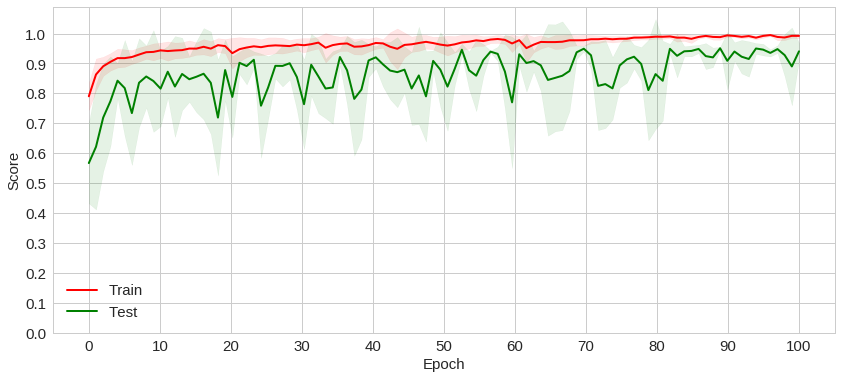

In [39]:
plot_mean_acc(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

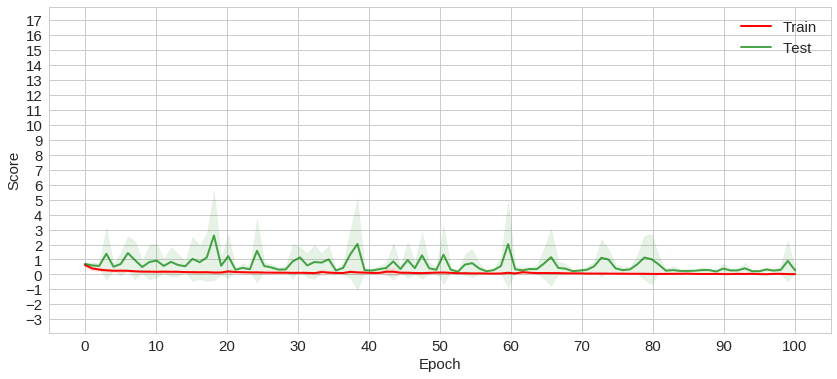

In [41]:
plot_mean_loss(hist)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-5, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

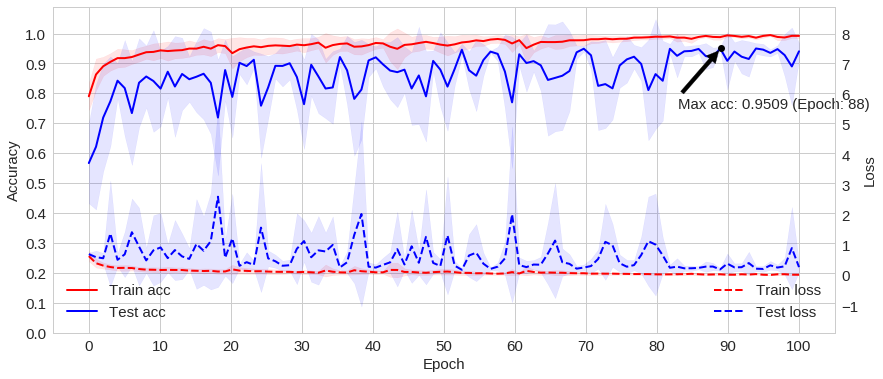

In [49]:
plot_mean(hist)